In [4]:
from neo4j import GraphDatabase
import pandas as pd


def read_csv(csv_file):
    data = pd.read_csv(csv_file)
    return data.to_dict(orient='records')

def import_data_to_neo4j(uri, username, password, universities_csv, courses_csv, students_csv, searches_csv, enrollment_csv):
    driver = GraphDatabase.driver(uri, auth=(username, password))

    universities_data = read_csv(universities_csv)
    courses_data = read_csv(courses_csv)
    students_data = read_csv(students_csv)
    searches_data = read_csv(searches_csv)
    enrollment_data = read_csv(enrollment_csv) 


    university_query = """
    UNWIND $data as row
    MERGE (u:University {id: row.id})
    SET u.name = row.name,
        u.country = row.country
    """


    course_query = """
    UNWIND $data as row
    MATCH (u:University {id: row.uni})
    MERGE (c:Course {id: row.id})
    SET c.name = row.name,
        c.year = row.year,
        c.semester = row.semester
    MERGE (c)-[:BELONGS_TO]->(u)
    """


    student_query = """
    UNWIND $data as row
    MERGE (s:Student {id: row.id})
    SET s.name = row.userid_DI,
        s.country = row.final_cc_cname_DI,
        s.education = row.LoE_DI,
        s.gender = row.gender,
        s.age = row.age
    """

   
    search_query = """
    UNWIND $data as row
    MATCH (s:Student {id: row.user})
    MERGE (search:Search {id: row.id})
    SET search.date = row.date,
        search.words = row.words
    MERGE (s)-[:SEARCHED]->(search)
    """

   
    enrollment_query = """
    UNWIND $data as row
    MATCH (s:Student {id: row.`student.id`})
    MATCH (c:Course {id: row.`course.id`})
    MERGE (s)-[enroll:ENROLLED_IN]->(c)
    SET enroll.viewed = row.viewed,
        enroll.explored = row.explored,
        enroll.certified = row.certified,
        enroll.ndays_act = row.ndays_act,
        enroll.incomplete_flag = row.incomplete_flag,
        enroll.comment = row.comment
    """


    def execute_query_in_batches(tx, query, data):
        BATCH_SIZE = 1000
        for i in range(0, len(data), BATCH_SIZE):
            batch = data[i:i + BATCH_SIZE]
            tx.run(query, data=batch)

  
    with driver.session() as session:
        session.write_transaction(execute_query_in_batches, university_query, universities_data)
        session.write_transaction(execute_query_in_batches, course_query, courses_data)
        session.write_transaction(execute_query_in_batches, student_query, students_data)
        session.write_transaction(execute_query_in_batches, search_query, searches_data)
        session.write_transaction(execute_query_in_batches, enrollment_query, enrollment_data)

    driver.close()


uri = "bolt://localhost:7687"
username = "neo4j"
password = "12345678" 


universities_csv = "univ.csv"
courses_csv = "course.csv"
students_csv = "student.csv"
searches_csv = "search.csv"
enrollment_csv = "enrollement.csv" 

import_data_to_neo4j(uri, username, password, universities_csv, courses_csv, students_csv, searches_csv, enrollment_csv)


C:\Users\Ghada\AppData\Local\Temp\ipykernel_26856\1942046945.py:83: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(execute_query_in_batches, university_query, universities_data)
C:\Users\Ghada\AppData\Local\Temp\ipykernel_26856\1942046945.py:84: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(execute_query_in_batches, course_query, courses_data)
C:\Users\Ghada\AppData\Local\Temp\ipykernel_26856\1942046945.py:85: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(execute_query_in_batches, student_query, students_data)
C:\Users\Ghada\AppData\Local\Temp\ipykernel_26856\1942046945.py:86: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(execute_query_in_batches, search_query, searches_data)
C:\Users\Ghada\AppData\Local\Temp\ipykernel_26856\1942046945.py:87: DeprecationWarning: write_transa

The most popular search terms are:
Web Development: 959 occurrences
Business Finance: 729 occurrences
Musical Instruments: 474 occurrences
Graphic Design: 316 occurrences
DevOps: 137 occurrences
Java: 102 occurrences
Machine Learning: 90 occurrences
Linux: 89 occurrences
Cloud: 79 occurrences
AI: 72 occurrences


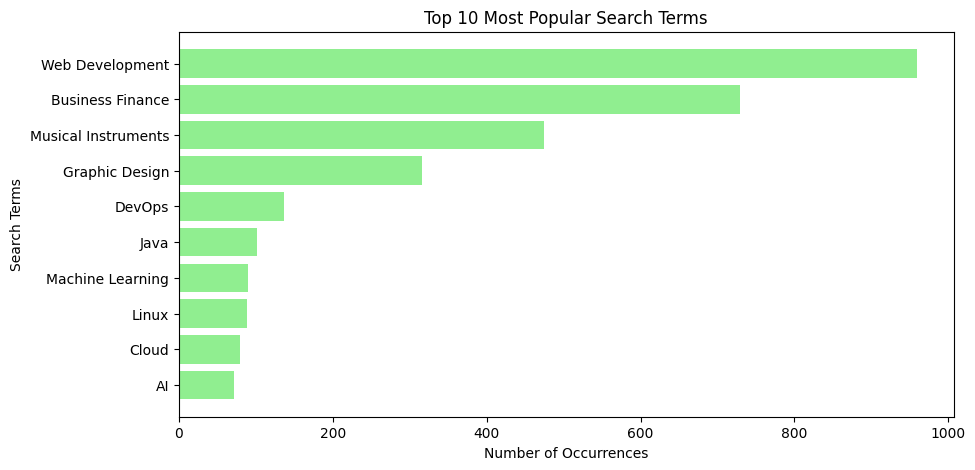

The most popular courses are:
PH207x: 1274 enrollments
CS50x: 1096 enrollments


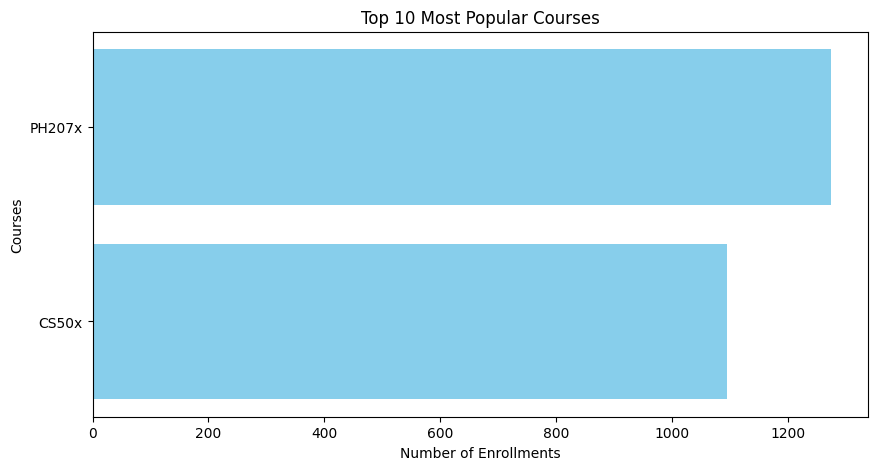

In [10]:
from neo4j import GraphDatabase
import matplotlib.pyplot as plt



def find_most_popular_search(tx):
        result = tx.run("""
        MATCH (search:Search)
        WITH search.words AS words, COUNT(*) AS count
        RETURN words, count
        ORDER BY count DESC
        LIMIT 10
        """)
        return result.data()

def find_most_popular_courses(tx):
        result = tx.run("""
        MATCH (s:Student)-[enroll:ENROLLED_IN]->(c:Course)
        WITH c.name AS course, COUNT(enroll) AS enrollments
        RETURN course, enrollments
        ORDER BY enrollments DESC
        LIMIT 2
        """)
        return result.data()

uri = "bolt://localhost:7687"
username = "neo4j"
password = "12345678"

driver = GraphDatabase.driver(uri, auth=(username, password))
with driver.session() as session:

        most_popular_search = session.execute_read(find_most_popular_search)
        most_popular_courses = session.execute_read(find_most_popular_courses)

driver.close()

if most_popular_search:
        print("The most popular search terms are:")
        for search in most_popular_search:
            print(f"{search['words']}: {search['count']} occurrences")

        # Plotting the most popular search terms
        search_terms = [search['words'] for search in most_popular_search]
        occurrences = [search['count'] for search in most_popular_search]

        plt.figure(figsize=(10, 5))
        plt.barh(search_terms, occurrences, color='lightgreen')
        plt.xlabel('Number of Occurrences')
        plt.ylabel('Search Terms')
        plt.title('Top 10 Most Popular Search Terms')
        plt.gca().invert_yaxis()
        plt.show()


    
if most_popular_courses:
        print("The most popular courses are:")
        for course in most_popular_courses:
            print(f"{course['course']}: {course['enrollments']} enrollments")
        
        courses = [course['course'] for course in most_popular_courses]
        enrollments = [course['enrollments'] for course in most_popular_courses]

        plt.figure(figsize=(10, 5))
        plt.barh(courses, enrollments, color='skyblue')
        plt.xlabel('Number of Enrollments')
        plt.ylabel('Courses')
        plt.title('Top 10 Most Popular Courses')
        plt.gca().invert_yaxis() 
        plt.show()


